**Heidelberg University**

**Data Science  Group**
    
Prof. Dr. Michael Gertz  

Ashish Chouhan, Satya Almasian, John Ziegler, Jayson Salazar, Nicolas Reuter
    
October 30, 2023
    
Natural Language Processing with Transformers

Winter Semster 2023/2024     
***

# **Assignment 1: “Word Embeddings and Probabilistic Language Models”**
**Due**: Monday, November 13, 2pm, via [Moodle](https://moodle.uni-heidelberg.de/course/view.php?id=19251)



### **Submission Guidelines**

- Solutions need to be uploaded as a **single** Jupyter notebook. You will find several pre-filled code segments in the notebook, your task is to fill in the missing cells.
- For the written solution, use LaTeX in markdown inside the same notebook. Do **not** hand in a separate file for it.
- Download the .zip file containing the dataset but do **not** upload it with your solution.
- It is sufficient if one person per group uploads the solution to Moodle, but make sure that the complete names of all team members are given in the notebook.

***

## **Task 1: F.R.I.E.N.D.S and  Word2Vec (Points (3 + 3 + 2) = 8)**

[Friends](https://en.wikipedia.org/wiki/Friends) is an American television sitcom, created by David Crane and Marta Kauffman. In this assignment we will use the transcripts from the show to train a Word2Vec model using the [Gensim](https://radimrehurek.com/gensim/) library.

### Subtask 1: Pre-processing
We start by loading and cleaning the data. Download the dataset for this assignment and load the `friends_quotes.csv` using pandas. The dataset is from Kaggle (https://www.kaggle.com/ryanstonebraker/friends-transcript) and is created for building a classifier that  determines which friend from the Friend's TV Show would be most likely to say a quote. The column `quote` contains a line from the movie and `author` is the one who said it. Since these are the only two columns we need, we remove the rest and only keep these two columns.

In [ ]:
import re
import pandas as pd
from collections import defaultdict
import spacy
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

✅ Point distribution ✅
- 0.5 points when file is loaded and 'author' and 'quote' columns are filtered. If columns other than 'author' and 'quote' are filtered then zero points or if any of the two columns are missing then zero points.

In [ ]:
df = pd.read_csv('./friends_quotes.csv')
df = df[['author','quote']]
df.head(10)

,author,quote
0,Monica,There's nothing to tell! He's just some guy I ...
1,Joey,"C'mon, you're going out with the guy! There's ..."
2,Chandler,"All right Joey, be nice. So does he have a hum..."
3,Phoebe,"Wait, does he eat chalk?"
4,Phoebe,"Just, 'cause, I don't want her to go through w..."
5,Monica,"Okay, everybody relax. This is not even a date..."
6,Chandler,Sounds like a date to me.
7,Chandler,"Alright, so I'm back in high school, I'm stand..."
8,All,"Oh, yeah. Had that dream."
9,Chandler,"Then I look down, and I realize there's a phon..."


Fortunately, there is no missing data, so we do not need to worry about that.

In [ ]:
df.isnull().sum() # check for missing data

author    0
quote     0
dtype: int64

Use SpaCy to preprocess the text. For this, perform the following steps:
- lowercase the words
- remove the stopwords and single characters
- use regex to remove non-alphabetic characters (anything that is not a number or alphabet including punctuations), in other words only keep "a" to "z" and digits.
- remove lines that have less than 4 words, since they cannot contribute much to the training process.

Please do not add any additional steps on your own or additional cleaning as we want to achieve comparable results.

✅ Point distribution ✅
- 0.5 points when all 4 pre-processing steps are performed if missed any one then zero points.

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser","ner"])
stopwords = spacy.lang.en.stop_words.STOP_WORDS
df["quote"] = df["quote"].apply(lambda x:re.sub("r[^A-Za-z\d']+", ' ', str(x)).lower())
quotes =[]
for script in df.quote.tolist():
    new_text=' '.join([token.text for token in nlp(script) if token.text not in stopwords and len(token.text)>1 ])
    if  len(new_text.split(' '))>3:
        quotes.append(new_text)

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


The next step is to build the vocabulary of the words and word combinations we want to learn representations from. We choose a subset of the most frequent words and bigrams to represent our corpus.
- Use the Gensim Phrases package to automatically detect common phrases (bigrams) from a list of lines from the previous step (`min_count=10`). Now words like New_York will be considered as one entity and character names like joey_tribbiani will be recognized.
- Create a list of words/bigrams with their frequencies and choose the top 15.000 words for the vocabulary, in order to keep the computation time-limited and to choose the most important words.

✅ Point distribution ✅
- 0.5 points when common phrases (bi-grams) are correctly identified otherwise zero points.

In [ ]:
from gensim.models.phrases import Phrases
words = [row.split(' ') for row in quotes]
phrases = Phrases(words, min_count=10, progress_per=10000)
new_lines = phrases[words]
new_lines[0]

["c'm", 'going', 'guy', 'got_ta', 'wrong']

✅ Point distribution ✅
- 0.5 points when top 50 words/bigrams exactly matches the provided words/bigrams if less than 50 words/bigrams matched then zero points.

In [ ]:
word_freq = defaultdict(int)
for sent in new_lines:
    for i in sent:
        word_freq[i] += 1
vocab= sorted(word_freq, key=word_freq.get, reverse=True)[:15000]

✅ Point distribution ✅

- 0.5 points: `word_freq['central_perk']` value is `36` for any other value zero points.
- 0.5 points: `word_freq['joey']` is 1951 for any other value zero points.

In [ ]:
word_freq['central_perk']

36

In [ ]:
word_freq['joey']

1879

####${\color{red}{Comments\ 1.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2: Training the Model


Use the Gensim implementation of Word2Vec to train a model on the scripts. The training can be divided into 3 stages:


1) Set up your model with parameters; define your parameters in such a way that the following conditions are satisfied:
 - ignore all words that have a total frequency of less than 2.
 - dimensions of the embeddings: 100
 - initial learning rate (step size) of 0.03
 - 20 negative samples
 - window size 3
 - the learning rate in the training will decrease as you apply more and more updates. Most of the time when starting with gradient descent the initial steps can be larger, and as we get close to the local minima it is best to use smaller steps to avoid jumping over the local minima. This adjustment is done internally using a learning rate scheduler. Make sure that the smallest learning rate does not go below 0.0001.
 - set the threshold for configuring which higher-frequency words are randomly down-sampled to 6e-5. This parameter forces the sampling to choose the very frequent words less often in the sampling.
 - set the hashfunction of the word2vec to the given function.
 - train on a single worker to make sure you get the same result as ours.

In [ ]:
from gensim.models import Word2Vec
def hash(astring):
    return ord(astring[0])

✅ Point distribution ✅
- 1.5 points when all the 8 hyper-parameters mentioned in the question are covered. If missed 1 to 4 hyper-parameter then 0.5 points and more than 4 hyper-parameter missed then zero points.

In [ ]:
w2v = Word2Vec(min_count=2,
                     window=3,
                     vector_size=100,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0001,
                     negative=20,
                     workers=1, hashfxn=hash)

2) Before training, Word2Vec requires us to build the vocabulary table by filtering out the unique words and doing some basic counts on them.
Use the `build_vocab` function to process the data. If you look at the logs you can see the effect of `min_count` and `sample` on the word corpus.

✅ Point distribution ✅
- 0.5 points if vocabulary table is built correctly with `new_lines` otherwise zero points.

In [ ]:
w2v.build_vocab(new_lines, progress_per=10000)

3) Finally, we  train the model. Train the model for 100 epochs. This will take a while. As we do not plan to train the model any further, we call `init_sims()`, which will make the model much more memory-efficient by precomputing L2-norms of word weight vectors for further analysis.

✅ Point distribution ✅
- 1 point when training of word2vec model is carried out otherwise if training is not successful or error then zero points.

In [ ]:
w2v.train(new_lines, total_examples=w2v.corpus_count, epochs=100, report_delay=1)


(12064977, 26754600)

####${\color{red}{Comments\ 1.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 3: Exploring the Model


As mentioned in the lecture, word embeddings are suited for similarity and analogy tasks. Let's explore some of that with our dataset:

We look for most similar words to the name of the famous coffee shop where most of the episodes took place, namely `central_perk` and also one of the characters `joey`. If you have followed the exercise correctly until now, you should see that words like `laying` are similar to `central_perk` and the other main characters are also considered similar to `joey`.



✅ Point distribution ✅
- 0.25 points if the answer matches the displayed result.

In [ ]:
w2v.wv.most_similar(positive=["central_perk"])

[('conan', 0.6685703992843628),
 ('sitting_couch', 0.5100923776626587),
 ('intrigued', 0.44448766112327576),
 ('continued', 0.43079474568367004),
 ('aaah', 0.4189146161079407),
 ('uhhh', 0.416584312915802),
 ('rehearsing', 0.4084688723087311),
 ('hippity', 0.406421959400177),
 ('crossword', 0.40370339155197144),
 ('mitzi', 0.4036918878555298)]

✅ Point distribution ✅
- 0.25 points if the answer matches the displayed result.

In [ ]:
w2v.wv.most_similar(positive=["joey"])

[('chandle', 0.7459915280342102),
 ('ross', 0.7339990735054016),
 ('rachel', 0.6974701881408691),
 ('monica', 0.6890754103660583),
 ('phoebe', 0.6026953458786011),
 ('ove', 0.5965407490730286),
 ('hey', 0.5781211256980896),
 ('right', 0.55622798204422),
 ('goes', 0.5538894534111023),
 ('looks', 0.5196943879127502)]

Look at the similarity of `mrs_green` to `rachel` (her mom) and `ross`  and `spaceship` (urelated). The first one should have a high and the second a low score. Finally, look at the similarity of `smelly_cat` ( a song from pheobe) and `song` the similarity should be high.

✅ Point distribution ✅
- 0.25 points if the answer matches the displayed result.

In [ ]:
w2v.wv.similarity('rachel', 'mrs_green')

0.4352267

✅ Point distribution ✅
- 0.25 points if the answer matches the displayed result.

In [ ]:
w2v.wv.similarity('ross', 'spaceship')

-0.16437878

✅ Point distribution ✅
- 0.25 points if the answer matches the displayed result.

In [ ]:
w2v.wv.similarity('smelly_cat', 'song')

0.52747095

We can also ask our model to give us the word that does not belong to a list of words. Let's see from the list of all 5 characters which one is the most dissimilar?


In [ ]:
character_names= ['joey', 'rachel', 'phoebe','monica','chandler']

✅ Point distribution ✅
- 0.25 points if the answer matches the displayed result.

In [ ]:
w2v.wv.doesnt_match(character_names)

'chandler'

Based on the analogies, which word is to `monica` as `man` is to `women`? (print the top 3 words); you should get `chandler`  among the answers.

✅ Point distribution ✅
- 0.5 points if the answer matches the displayed result.

In [ ]:
w2v.wv.most_similar(positive=["man", "monica"], negative=["women"], topn=3)

[('chandle', 0.6718476414680481),
 ('ross', 0.5510697960853577),
 ('joey', 0.5449243187904358)]

Finally, lets use [t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) to look at the distribution of our embeddings in the vector space for the character `joey`. Follow the instructions and fill in the blank in the `tsneplot` function.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
from sklearn.manifold import TSNE

In [ ]:
def tsneplot(model, word):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction for the top 10 most similar and dissimiliar words
    """
    embs = np.empty((0, 100), dtype='f')# to save all the embeddings
    word_labels = [word]
    color_list  = ['green']

    # adds the vector of the query word
    embs = np.append(embs, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    all_sims = model.wv.most_similar([word], topn=sys.maxsize)
    far_words = list(reversed(all_sims[-10:]))

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        embs = np.append(embs, wrd_vector, axis=0)

    # adds the vector for each of the furthest words to the array
    for wrd_score in far_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('red')
        embs = np.append(embs, wrd_vector, axis=0)

    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=110, perplexity=15).fit_transform(embs)

    # sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(10, 10)

    # basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-1, Y[:, 0].max()+1)
    plt.ylim(Y[:, 1].min()-1, Y[:, 1].max()+1)

    plt.title('t-SNE visualization for {}'.format(word.title()))


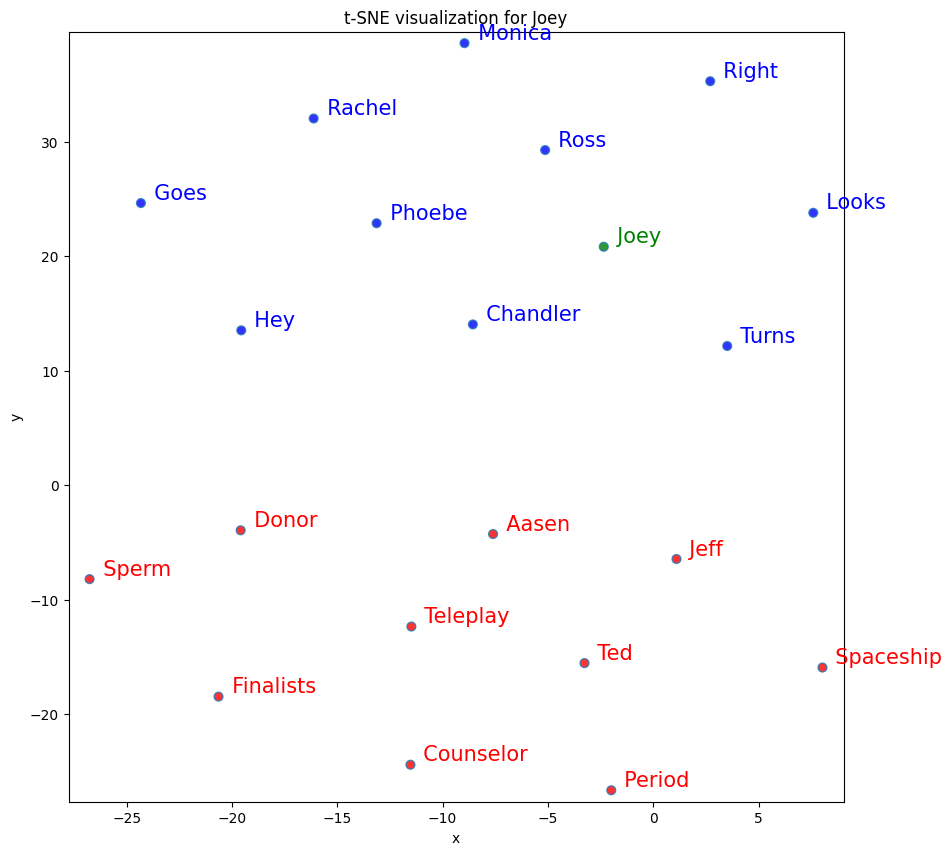

In [ ]:
tsneplot(w2v, 'joey')

####${\color{red}{Comments\ 1.3}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

## **Task 2: Questions on the Conceptual Level (non-programming) (Points (2 + 1 + 1 + 4) = 8)**

Please answer the following questions in the notebook cells using markdown. Be percise and short.

### Subtask 1: For gradient descent, what advantage has a decaying learning rate?

✅ Point distribution ✅
- 2 points if answer comprises of both the highlighted text or text having interpretation similar to highligted text. If only one highlighted text or its interpretation is present then 1 point otherwise zero points.

Decaying learning has the advantage that at the beginning of training where the model weights are usually
chosen at random, **the algorithm can fastly converge towards a minimum**. After more and more steps, it can be
assumed that the **solution is near such a minimum, and only smaller steps are taken**, such that the algorithm can
now "fine-tune" model parameters, instead of altering weights massively, potentially stepping over the optimal
the solution again and again.

####${\color{red}{Comments\ 2.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2: Why is it easier to maximize the log likelihood instead of the "normal" likelihood?

✅ Point distribution ✅
- 1 point if answer comprises of the highlighted text otherwise zero points.

The advantage of using the log likelihood is that **the derivative is a sum instead of a product**. On one hand
this makes math easier for us. On the other hand, this means that the individual terms are independent from
each other. Additionally, calculating sums instead of products is numerically more stable, hence, making it more
suitable for computer applications.

####${\color{red}{Comments\ 2.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 3: Name one advantage that fastText has over Word2Vec?

✅ Point distribution ✅
- 1 point if answer comprises of the highlighted text or interpretation of highlighted text, otherwise zero points.

FastText considers **subwords (character n-grams), such that a word embedding does not consider only the word itself but also a set of substrings of the word**. This has the advantage that also previously unseen words
(or rare words in general) can have a meaningful vector representation if the substrings are known to the model.

####${\color{red}{Comments\ 2.3}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 4: Compute the partial derivate of softmax loss for word2vec with respect to the center word vector.
$$ \frac{\partial J}{\partial v_c} =\frac{\partial}{\partial v_c}\left[ -log \left( \frac{exp(u^T_o v_c)}{\Sigma_{w \in Vocab} exp(u^T_o v_c)} \right)\right] $$
use $U$ to denote the matrix of all embeddings and $y$ for a one-hot vector with a 1 for the true outside word $o$, and $\hat{y}$ for the predicted distribution $P(w|c)$.

✅ Point distribution ✅
- alloted points for the step is mentioned below the step (step-marking)

$$ \frac{\partial J}{\partial v_c} =\frac{\partial}{\partial v_c}\left[-log \left(\frac{exp(u^T_o v_c)}{\Sigma_{w \in Vocab} exp(u^T_w v_c)}\right)\right]= $$

$$ \frac{\partial}{\partial v_c}\left[- \left(log (exp(u^T_o v_c)) - log(\Sigma_{w \in Vocab} exp(u^T_w v_c)) \right)\right]= $$
**0.5 points**

$$ \frac{\partial}{\partial v_c}\left[ log \left( \Sigma_{w \in Vocab} exp(u^T_w v_c))\right) - u^T_o v_c)\right]$$

$$ \Sigma_{w \in Vocab} \frac{ exp(u^T_w v_c u_w)}{\Sigma_{w \in Vocab} exp(u^T_o v_c )} - u_o $$
**0.5 points**

$$ \Sigma_{w \in Vocab} \frac{ exp(u^T_w v_c)}{\Sigma_{w \in Vocab} exp(u^T_o v_c )}u_w - u_o $$
$$ \Sigma_{w \in Vocab}P(w|c)u_w - u_o $$
**1.25 points**

$$  \Sigma_{w \in Vocab} \hat{y_w}u_w - u_o $$
$$  U \hat{y_w} - u_o $$
**1.25 points**
$$  U \hat{y_w} - Uy $$
$$  U (\hat{y_w} - y) $$
**0.5 points**

####${\color{red}{Comments\ 2.4}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

## **Task 3: Auto-Complete Feature (Points (2 + 6 + 4) = 12)**

Let's get even more practical! In this problem set, you will build your own auto-completion system that you see every day while using search engines.

[google]: https://www.thedad.com/wp-content/uploads/2018/05/screen-shot-2018-05-12-at-2-01-56-pm.png "google auto complete"

![google]
By the end of this assignment, you will develop a simple prototype of such a system using n-gram language model. At the heart of the system is a language model that assigns the probability to a sequence of words. We take advantage of this probability calculation to predict the next word.

The problem set contains 3 main parts:

1. Load and preprocess data (tokenize and split into train and test)
2. Develop n-gram based language model by estimating the conditional probability of the next word.
3. Evaluate the model by computing the perplexity score.


### Subtask 1: Load and Preprocess Data
We use a subset of English tweets to train our model. Run the cell below to load the data and observe a few lines of it. Notice that tweets are saved in a text file, where the individual tweets are separated by `\n`

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser","ner"])


with open("./twitter.txt", "r") as f:
    data = f.read()
print("First 500 characters of the data:")
display(data[0:500])
print("-------")

First 500 characters of the data:


"How are you? Btw thanks for the RT. You gonna be in DC anytime soon? Love to see you. Been way, way too long.\nWhen you meet someone special... you'll know. Your heart will beat more rapidly and you'll smile for no reason.\nthey've decided its more fun if I don't.\nSo Tired D; Played Lazer Tag & Ran A LOT D; Ughh Going To Sleep Like In 5 Minutes ;)\nWords from a complete stranger! Made my birthday even better :)\nFirst Cubs game ever! Wrigley field is gorgeous. This is perfect. Go Cubs Go!\ni no! i ge"

-------


Now we need to separate the tweets and split them into train and test set. Apply the following pre-processing steps:

1. Split data into sentences using "\n" as the delimiter and remove the leading and trailing spaces (drop empty sentences)
2. Tokenize the sentences into words using SpaCy and lowercase them. (notice that we do not remove stop words or punctuations.)
3. Divide the sentences into 80 percent training and 20 percent test set. No validation set is required. Although in a real-world application it is best to set aside part of the data for hyperparameter tuning.
4. To limit the vocabulary and remove potential spelling mistakes, make a vocabulary of the words that appear at least 2 times. The rest of the words will be replaced by the `<unk>` symbol. This is a crucial step since if your model encounters a word that it never saw during training, it won't have an input word that helps determining the next word for suggestion. We use the `<unk>` word for **out of Vocabulary (OOV)** words. Keep in mind that we built the vocabulary on the training data only.

✅ Point distribution ✅
- 0.25 points if data is splitted into sentences using "\n" **AND** trailing and leading spaces are removed otherwise zero points.

In [ ]:
sentences = data.split('\n')
sentences = [s.strip() for s in sentences if len(s.strip()) > 0]

✅ Point distribution ✅
- 0.25 points if sentences are tokenized into words using spacy **AND** lowercase them.
- zero points if sentences are not tokenized using spacy and lowercased or removed stop words or punctuations

In [ ]:
tokenized_corpus = []# list of list of the tokens in a sentence
for sentence in sentences:
    tokenized_corpus.append([token.text.lower() for token in nlp(sentence)])

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


✅ Point distribution ✅
- 0.5 points if 80% training and 20% testing split is performed otherwise zero points.

In [ ]:
from random import Random
Random(4).shuffle(tokenized_corpus)

train_size = int(len(tokenized_corpus) * 0.8)
train = tokenized_corpus[0:train_size]
test = tokenized_corpus[train_size:]

✅ Point distribution ✅
- 1 point when count value of `print(len(vocab))` matched the displayed result **AND** `<unk>` is tackled.
- 0.5 points:
  - if count value does not match but `<unk>` is tackled.
  - if `<unk>` is not tackled but count value matches

In [ ]:
from collections import Counter
flatten_corpus = [token for sentence in train for token in sentence]
word_counts = Counter(flatten_corpus)
vocab = []
for word, cnt in word_counts.items():
    if cnt >= 2:
        vocab.append(word)
vocab = set(vocab)
train_replaced = []
test_replaced = []
for sentence in train:
    train_replaced.append([token if token in vocab else '<unk>' for token in sentence ])
for sentence in test:
    test_replaced.append([token if token in vocab else '<unk>' for token in sentence ])
print(len(vocab))

14861


####${\color{red}{Comments\ 3.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2: N-gram Based Language Model:
In this section, you will develop an n-grams language model [**1. Large Language Models (LLMs), slide 1-24**]. We assume that the probability of the next word depends only on the previous n-gram or previous n words. We compute this probability by counting the occurrences in the corpus.
The conditional probability for the word at position 't' in the sentence, given that the words preceding it are $w_{t-1}, w_{t-2} \cdots w_{t-n}$ can be estimated as follows:

$$ \hat{P}(w_t | w_{t-1}\dots w_{t-n}) = \frac{C(w_{t-1}\dots w_{t-n}, w_t)}{C(w_{t-1}\dots w_{t-n})}  $$

The numerator is the number of times word '$w_t$' appears after the n-gram, and the denominator is the number of times the n-gram occurs in the corpus, where $C(\cdots)$ is a count function. Later, we add k-smoothing to avoid errors when any counts are zero.

To tackle the problem of probability estimation we divide the problem into 3 parts. In the following you will:
1. Implement a function that computes the counts of n-grams for an arbitrary number n.
2. Estimate the probability of a word given the prior n-words using the n-gram counts.
3. Calculate probabilities for all possible words.
The steps are detailed below.

Let's start by implementing a function that computes the counts of n-grams for an arbitrary number n.
- Prepend necessary starting markers `<s>` to indicate the beginning of the sentence. In the case of a bi-gram model, you need to prepend two start tokens `<s><s>` to be able to predict the first word. "hello world"-> "`<s><s>`hello world".
- Append an end token `<e>` so that the model can predict when to finish a sentence.
- Create a dictionary to store all the n_gram counts.

✅ Point distribution ✅
- 2 points when function implementation is correct
- 1 point:
  - if n-gram count implementation is correct but start and end token is not added.
- 0.5 points:
  - if n-gram count implementation is wrong but start and end token is added.

In [ ]:
def n_grams_counts(corpus, n ):
    """
    Count all n-grams in the corpus given the parameter n

    data: List of lists of words (your tokenized corpus)
    n: n in the n-gram

    Returns: A dictionary that maps a tuple of n words to its frequency
    """
    start_token='<s>'
    end_token = '<e>'
    n_grams = defaultdict(lambda:1)
    for sentence in corpus:
        sentence = [start_token] * n+ sentence + [end_token]
        # convert list to tuple so it can be used a the key in the dictionary
        sentence = tuple(sentence)
        m = len(sentence)+1-n
        for i in range(m):
            # Get the n-gram from i to i+n
            n_gram = sentence[i:i+n]
            n_grams[n_gram] += 1
    return n_grams

The next step is to estimate the probability of a word given the prior n words using the n-gram counts, based on the formula given at the beginning of this task. To deal with the problem of zero division we add k-smoothing. K-smoothing adds a positive constant $k$ to each numerator and $k \times |vocabulary size|$ in the denominator. Below we will define a function that takes in a dictionary `n_gram_cnt`, where the key is the n-gram, and the value is the count of that n-gram, plus a dictionary for `plus_current_gram_cnt`, which you'll use to find the count for the previous n-gram plus the current word. Notice that these dictionaries are computed using the previous function `n_grams_counts`.


✅ Point distribution ✅
- 2 points when function implementation is correct with all the variables populated otherwise zero points.

In [ ]:
def probability(word, prev_n_gram,
                         n_gram_cnts, plus_current_gram_cnts, vocab_size):
    """
    Estimate the probabilities of a next word using the n-gram counts with k-smoothing
    word: next word
    prev_n_gram: previous n gram
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab_size: number of words in the vocabulary

    Returns: A probability
    """
    k=1.0
    prev_n_gram = tuple(prev_n_gram)

    prev_n_gram_cnt = n_gram_cnts.get(prev_n_gram,0) # get the previous n-gram count from
    #the dictionary
    denominator = prev_n_gram_cnt + k * vocab_size # denominator with the previous n-gram count and k-smoothing
    plus_current_gram = prev_n_gram + (word,) # add the current word to the n-gram
    plus_current_gram_cnt = plus_current_gram_cnts.get(plus_current_gram,0)  # get the current n-gram
    # count using the dictionary
    numerator = plus_current_gram_cnt + k #calculate the numerator with k-smoothing
    prob = numerator / denominator

    return prob

Let's use the functions we have defined to calculate probabilities for all possible words.


In [ ]:
def probabilities(prev_n_gram, n_gram_cnts, plus_current_gram_cnts, vocab):
    """
    Estimate the probabilities for all the words in the vocabulary
    prev_n_gram: previous n gram
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab: List of words

    Returns: A dictionary mapping from next words to the probability.
    """
    prev_n_gram = tuple(prev_n_gram)

    vocab = vocab + ["<e>", "<unk>"] # add <e> <unk> to the vocabulary
    vocabulary_size = len(vocab)
    probabilities = {}
    for word in vocab:
        probabilities[word] = probability(word, prev_n_gram, n_gram_cnts, plus_current_gram_cnts,vocabulary_size)
    return probabilities

✅ Point distribution ✅
- 2 points when "moon" is having the highest probability `0.25`.
- 1 point when "moon" is having the highest probability but value other than `0.25`.
- zero points if "moon" is not having highest probability.

In [ ]:
# Predict the probability of the all possible words after the unigram "the"
sentences = [['the', 'moon', 'and', 'stars', 'are','shining','bright'],
             ['the', 'moon', 'is', 'shinnig','tonight'],
             ['mars','and' ,'moon', 'are', 'plants'],
             ['the' ,'moon', 'is','a', 'plant']]
unique_words = list(set(sentences[0] + sentences[1] + sentences[2]+ sentences[3]))
unigram_counts = n_grams_counts(sentences, 1)
bigram_counts = n_grams_counts(sentences, 2)
print("The word 'moon' should have the highest probability, if it is not the case, re-visit your previous functions.")
probabilities(["the"], unigram_counts, bigram_counts, unique_words)

The word 'moon' should have the highest probability, if it is not the case, re-visit your previous functions.


{'and': 0.05,
 'tonight': 0.05,
 'mars': 0.05,
 'stars': 0.05,
 'moon': 0.25,
 'shining': 0.05,
 'is': 0.05,
 'a': 0.05,
 'bright': 0.05,
 'plant': 0.05,
 'shinnig': 0.05,
 'are': 0.05,
 'plants': 0.05,
 'the': 0.05,
 '<e>': 0.05,
 '<unk>': 0.05}

####${\color{red}{Comments\ 3.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 3: Evaluation

In this part, we use the perplexity score to evaluate your model on the test set. The perplexity score of the test set on an n-gram model is defined as follows:

$$ PP(W) =\sqrt[N]{ \prod_{t=n}^{N-1} \frac{1}{P(w_t | w_{t-n} \cdots w_{t-1})} } $$
- where $N$ is the length of the sentence. ($N-1$ is used because in the code we start from the index 0).
- $n$ is the number of words in the n-gram.
- $W$ is the n-gram

Notice that we have already computed this probability.

The higher the probabilities are, the lower the perplexity will be.

✅ Point distribution ✅
- 1 point when all 7 code placeholder are matching the solution.
- 0.5 points when code in the for loop are matching the solution
- 0 points when code inside the loop are not matching the solution

In [ ]:
def perplexity(sentence, n_gram_cnts, plus_current_gram_cnts, vocab_size):
    """
    Calculate perplexity for a sentence
    sentence: List of strings
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab_size: number of unique words in the vocabulary

    Returns: Perplexity score for a single sentence
    """

    n = len(list(n_gram_cnts.keys())[0]) # get the number 'n' in  n-gram  from n_gram_cnts

    sentence = ["<s>"] * n + sentence + ["<e>"] # prepend <s> and append <e>
    sentence = tuple(sentence)
    N = len(sentence)# length of sentence


    product_pi = 1.0

    ### Compute the product of probabilites ###

    for t in range(n, N):
        n_gram = sentence[t-n:t]# get the n-gram before the predicted word (n-gram before t )
        word = sentence[t] # get the word to be predicted (position t)
        prob = probability(word,n_gram, n_gram_cnts, plus_current_gram_cnts, vocab_size)
        product_pi *= 1 / prob # Update the product of the probabilities

    perplexity = product_pi**(1/float(N)) # Take the Nth root of the product
    return perplexity

Use `perplexity` function to find the perplexity of a bi-gram model on the first training sample and on the first test sample (first element of the set).

✅ Point distribution ✅
- Perplexity for first train sample: 125.3628 (0.5 points)
- Perplexity for test sample: 2389.7532 (0.5 points)


In [ ]:
bigram_counts = n_grams_counts(train_replaced, 2)
trigram_counts = n_grams_counts(train_replaced, 3)

perplexity_train = perplexity(train_replaced[0],bigram_counts, trigram_counts,len(vocab))
print(f"Perplexity for first train sample: {perplexity_train:.4f}")

perplexity_test = perplexity(test_replaced[0],bigram_counts, trigram_counts,len(vocab))
print(f"Perplexity for test sample: {perplexity_test:.4f}")# the preprexity for the train sample should be much lower

Perplexity for first train sample: 125.3628
Perplexity for test sample: 2389.7532


Finally, let's use the model we created to generate an auto-complete system that makes suggestions.

In [ ]:
def suggest_a_word(up_to_here, n_gram_cnts, plus_current_gram_cnts, vocab , start_with=None):
    """
    Get suggestion for the next word
    up_to_here: the sentence so far, must have length => n
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab: List of words
    start_with: If not None, specifies the first few letters of the next word

    Returns: (most likely next word,  probability)
    """
    n = len(list(n_gram_cnts.keys())[0]) # get the number 'n' in  n-gram  from n_gram_cnts
    up_to_here = up_to_here[-n:] # get the last 'n' words as the previous n-gram from the input sentence

    # Estimate the probabilities for each word in the vocabulary
    probabs = probabilities(up_to_here,n_gram_cnts, plus_current_gram_cnts,vocab)

    probabs = {k: v for k, v in sorted(probabs.items(), key=lambda item: item[1], reverse=True)}
    if start_with is None:
        next_item= next(iter(probabs))
        return (next_item,probabs[next_item])
    else:
        for word, prob in probabs.items():
            if word.startswith(start_with):
                return (word, prob)
    return(None,0)


Test your model based on the bi-gram model created on the training corpus.

✅ Point distribution ✅
- 0.5 points when 'baseball' is answer otherwise zero points


In [ ]:
previous_tokens=['i','like']
start_with='b'
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

('baseball', 0.0001998534408100726)

✅ Point distribution ✅
- 0.5 points when 'see' is answer otherwise zero points

In [ ]:
previous_tokens=['i','like','to']
start_with=None
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

('see', 0.0006685385746757588)

✅ Point distribution ✅
- 0.5 points when `<unk>` is answer otherwise zero points

In [ ]:
previous_tokens=["hello", "my", "name", "is"]
start_with=None
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

('<unk>', 0.0004702089071001545)

✅ Point distribution ✅
- 0.5 points when 'allison' is answer otherwise zero points

In [ ]:
previous_tokens=["hello", "my", "name", "is"]
start_with='a'
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

('allison', 0.00020151810304292335)

####${\color{red}{Comments\ 3.3}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

## **Task 4: Understanding GloVe (Points (2 + 4.25 + 4 + 1.75) = 12)**

In this part, you will implement the [GloVe](https://nlp.stanford.edu/projects/glove/) model and train your own word vectors with gradient
descent and numpy. GloVe stands for Global Vectors for word representation, which was developed by researchers at Stanford University to generate word embeddings from corpus statistics.
The statistics of the corpus are represented by a co-occurrence matrix, indicating how often a particular word pair occurs together.
GloVe is based on ratios of probabilities from this co-occurrence matrix, combining the intuitions of count-based models while also being similar to neural models like word2vec.
From this matrix, one can compute the co-occurrence probabilities. We motivate this with an example:

$P_{ik} = P(i,j)$ -> co-occurrence probability or joint probability of words $i$ and $k$

$P_{jk}$ ->co-occurrence probability of words $j$ and $k$

$\frac{P_{ik}}{P_{jk}}$-> corelation between $i$ and $j$ with the prob word $k$

This ratio gives us some insight into the co-relation of the probe word $k$ with the words $i$ and $j$.
An example is shown below for different prob words $k$, where $i$ and $j$ are `ice` and `steam`, respectively.


![glove](https://nlp.stanford.edu/projects/glove/images/table.png)


Image taken from Stanford NLP.

As shown in the example above, compared to the raw probabilities, the ratio of probabilities is better able to distinguish relevant words from irrelevant words. Consider the raw probabilities (the first two rows of the table), the values are close to one another and not indicative of the relationships. However, the ratios (bottom row) have more distinct values.

This ratio can be small, large, or equal to 1 depending on the prob word and its co-relation. In the example above, the ratio between `ice` and `steam` for `k=solid` is large and for `k=gas` is small, indicating that `solid` is related to ice but `gas` is irrelevant. On the other hand, `water` is not a discriminating element between `ice` and `steam`, and therefore the ratio is close to one. The same applies to an irrelevant word like `fashion`, where the ratio is once again close to one.

The GloVe model is built on the idea that the "ratio of conditional probabilities represents the word meanings", and a neural model is trained to estimate this conditional probability.
The GloVe model primarily aims to estimate the following function $F$:

$F(w_i,w_j,\tilde{w_k})=\frac{P_{ik}}{P_{jk}}$ -> the right-hand side is computed from the corpus statistics, $w$ is the word vector and $\tilde{w_k}$ is the context vector.

The GloVe model embeds the words in a vector space and claims that the difference between these vectors (distinguishing factor) is hidden in the ratio of probabilities. In vector space, the best way to encode this is by vector differences.
In other words, GloVe trains a neural model such that the difference between the word vectors encodes the ratio of probabilities.

$F((w_i-w_j),\tilde{w_k})=\frac{P_{ik}}{P_{jk}}$

At this point, the left side is a vector and the right-hand side is a scalar showing the similarity of $i$ and $j$ in relation to the context word $k$.
For both sides to become scalar values, the left-hand side becomes a dot product. This is convenient since similarity in vector space is often encoded via a dot product.

$F((w_i-w_j)^{T}.\tilde{w_k})=\frac{P_{ik}}{P_{jk}}=\frac{F(w_i.\tilde{w_k})}{F(w_j.\tilde{w_k})} $

The nominator and the denominator are probabilities that can be computed using the co-occurrence matrix.

$F(w_i.\tilde{w_k})=\frac{X_{ik}}{X_{i}}$ -> where $X$ is the co-occurrence matrix

There are multiple choices for the function $F$. To satisfy a symmetrical relationship (a.k.a. relation(a, b) = relation(b, a)), $F$ is chosen to be an exponential function, $F(x)=exp(x)$. As a result:

$w_i.\tilde{w_k} = log(P_{ik} ) = log(X_{ik} ) − log(X_{i})$

$log(X_{i})$ is independent of $k$ and can be absorbed into a bias term (a constant number).

$w_i.\tilde{w_k} = log(P_{ik} ) + b_i +\tilde{b_k} = log(X_{ik} )$

After some weighting and alterations the final cost function, based on the weighted least squares regression model is as follows:

$J= \Sigma^{V}_{i,j=1} f(X_{ij})(w_i.w_j+ b_i +b_j)-log(X_{ik})$

For a detailed overview refer to the original paper: https://nlp.stanford.edu/pubs/glove.pdf
You need to read and understand the GloVe model in order to solve this exercise.


### Subtask 1: Cost function

Read the paper and describe the following, in your own words:

1. The intuition behind the weighting schema in the cost function. # 1 point

2. How does the objective function of GloVe relate to the objective function of the (word2vec) skip-gram model? # 1 point

✅ Point distribution ✅
- 1 point each for two questions, i.e., 2 points if answer comprises of the highlighted text or text having interpretation similar to highligted text
- Otherwise zero points

**Answer :**

1) A main drawback to this model is that it **weighs all co-occurrences equally, even those that happen rarely or never**. Such rare cooccurrences are noisy and carry less information
than the more frequent ones.
$f$ is a weighting function that acts to reduce the impact of frequent co-occurring terms which is a drawback discussed above.
When the co-occurrence count is higher or equal to a threshold, say 100, the weight will be 1. Otherwise, the weight will be smaller, subject to the co-occurrence count.

2) The Word2vec model attempts to maximize the log probability as a context window scans over the corpus. The global objective function is:

$J= - \Sigma_{i \in corpus, j \in context(i)} log \frac{w_i^T.\tilde{w_j}}{\Sigma^{V}_{k=1} w_i^T.\tilde{w_k}}=- \Sigma_{i \in corpus, j \in context(i)} log Q_{ij}$

The denominator is a sum over the vocabulary and is very costly, therefore, word2vec comes up with an approximation for this with negative sampling.
However, the **fraction can be efficiently estimated if we first group together those terms that have the same values for $i$ and $j$. We can get the co-occurrences from the co-occurrence matrix**.

$J= - \Sigma_{i}^{V}\Sigma_{j}^{V}X_{ij}Q_{ij}$

Moreover, the number of occurrences of $i$ is given by a row in $X$ as $X_i=\Sigma_k X_{ik}$ and $P_{ij}= \frac{X_{ij}}{X_i}$. Then we can re-write $J$ as:

$J= - \Sigma_{i}^{V} X_i\Sigma_{j}^{V}P_{ij}Q_{ij} = \Sigma_{i}^{V} X_i H(P_i,Q_i) $

Where $H$ is the cross entropy of $P$ and $Q$. The whole equation is a weighted cross entropy, which bears some formal resemblance to the weighted least squares objective of GloVe.

####${\color{red}{Comments\ 4.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2: Build Co-occurence matrix


We use the same dataset as in the first task and use the `quotes` as the corpus to build the co-occurrence matrix. Similar to the first task, we use the `phrases` to transform our input and extract the vocabulary that also includes bi-grams.

In [ ]:
import numpy as np
from scipy import sparse
from math import log
from itertools import chain
from collections import Counter
from tqdm import tqdm

Complete the function to create dictionaries used for mapping ids to words and words to ids, and a dictionary that counts the number of occurrences of each word. The first two dictionaries are used to map indices in vector space to words and back, the third dictionary contains the counts of the corpus statistics.

In [ ]:
def create_vocab(corpus): # 1 point
  """
  Build a vocabulary containing the frequencies
  corpus: the list of tokenized lines form the corpus

  Returns  dictionaries `word` -> (index or unique identified), frequency)`
  and `word` -> (index or unique identified)
  and index or unique identified -> `word`
  and length of the vocab
  """

  word_count_dict = {}
  id_to_word={}
  word_to_id={}
  count = Counter(chain(*corpus))
  for index,word in enumerate(count.keys()):
      id_to_word[index]= word
      word_to_id[word]=index
      word_count_dict[index]= count[word]


  return word_count_dict,id_to_word,word_to_id, len(word_count_dict)

In [ ]:
word_count_dict, id_to_word,word_to_id, vocab_size=create_vocab(new_lines)

✅ Point distribution ✅
- 0.5 points is the total tokens are correct and 0.5 points if the number of occurrance are correct

If you have done the exercise correctly, you have `15333` tokens in the vocabulary, and the number of occurrences for `joey` is `1951` and for `central_perk` is `36`

In [ ]:
print("number of occurances for joey:",word_count_dict[word_to_id['joey']])
print("number of occurances for central perk:",word_count_dict[word_to_id['central_perk']])
print("vocab size is:",vocab_size)

number of occurances for joey: 1879
number of occurances for central perk: 36
vocab size is: 17234


In [ ]:
def calculate_weight(cooccurrences, context_word_ids, center_word_id, side):  # 1.25 point
    """
    Calculate the weight in the co-occurrence matrix based on the distance of a word
    to the center word
    sentence = [I, went, to , the, bank]
    Let center word be "to" and window size =2
    left_context =[I,went]
    right_context = [the,bank]

    Weights:
    1/distance-> `went` and `the` have weight of 1 and `I` and `bank` have weight of 1/2
    """

    if side == "right_context":
        context_word_ids.reverse()

    #len of context_word_ids will be used while calculating distance
    number_of_context_words = len(context_word_ids)

    for i in range(number_of_context_words):
        distance = number_of_context_words - i
        weight = 1 / float(distance)

        #center word will act as the row and the context word is the column
        cooccurrences[center_word_id, context_word_ids[i]] += weight

    return cooccurrences



The weight of first to second element on the example matrix should be `1.0`.

In [ ]:
cooccurrences = sparse.lil_matrix((10, 10),dtype=np.float64)
calculate_weight(cooccurrences, [1,3,5], 0, side="right_context")
print("weight of id=0 to id=1 :",cooccurrences[0,1])

weight of id=0 to id=1 : 1.0


✅ Point distribution ✅
- 0.25 points if weight of id=0 to id=1 : 1.0.
- 0.5 points if the weights are 1 / float(distance)
- 0.5 points if the position of the context and center word are correct in the matrix

We build co-occurrence as a sparse matrix to speed up the computation. The original matrix is a square matrix in the size of the vocabulary. However, many words do not co-occur with one another and we do not need to store those elements.

In [ ]:
def build_cooccur(corpus, window_size=3, min_count=5): # 2 points
    """
    Create a coocurrance matrix given a corpus
    corpus: the list of tokenized lines form the corpus
    window_size: how many words to right and left to consider

    Returns the co-oocurrance sparse matrix
    """
    vocab, id_to_word,word_to_id, vocab_size= create_vocab(corpus)

    #sparse lil_matrix is optimized to operate on matrix which mostly has zeros.
    cooccurrences = sparse.lil_matrix((vocab_size, vocab_size),dtype=np.float64)

    for i, line in enumerate(corpus):

        #Get the ID of words from vocab dictionary
        word_ids = [word_to_id[word] for word in line]

        for i, center_word_id in enumerate(word_ids):
            #left side context
            left_context_word_ids  = word_ids[max(0, i-window_size):i]

            #right side context
            right_context_word_ids = word_ids[i+1: i+window_size]

            #update the matrix based on the distance weights on both sides
            cooccurrences = calculate_weight(cooccurrences, left_context_word_ids, center_word_id,"left_context")
            cooccurrences = calculate_weight(cooccurrences, right_context_word_ids, center_word_id,"right_context")

    # go into the LiL-matrix to quickly iterate through all nonzero cells and filter out the ones with minimum count
    cooccurrences_tuples = []
    for i, (row, data) in enumerate(zip(cooccurrences.rows,cooccurrences.data)):
        if min_count is not None and vocab[i] < min_count:
            continue

        for data_idx, j in enumerate(row):
            if min_count is not None and vocab[j] < min_count:
                continue

            cooccurrences_tuples.append((i, j, float(data[data_idx])))
    return cooccurrences_tuples


Build a matrix with a window_size of 3 words, and the minimum number of times a word has to occur to be part of the matrix is 10.

In [ ]:
matrix=build_cooccur(new_lines, window_size=3, min_count=10)
matrix[103]

(0, 998, 1.0)

✅ Point distribution ✅
- 0.25 points if the output of matrix[103] is (0, 1136, 1.0)
- 0.75 points if the left and right side context are choosen correctly from `word_ids`
- 0.5 points for update of the matrix
- 0.5 points for skipping words less than `min_count` and creating the correct format for the `cooccurrences_tuples`

####${\color{red}{Comments\ 4.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 3: Modelling and Training


We initialize the weights for the context and center words and learn the vectors through backprop, using the GloVe cost function.
Make sure you use the correct weighting schema.

✅ Point distribution ✅
- 0.5 points for correct shape of the weight vectors
- 0.5 points for correct shape of the biases

In [ ]:
# Random normal weights intialization
np.random.seed(77)# we set a seed to have similiar results
def init_weights(vocab_size, hidden):
     #Each word has a center word vector and a context vector.
    W_center = np.random.randn(vocab_size, hidden)
    b_center = np.random.randn(vocab_size, 1)
    W_context = np.random.randn(vocab_size, hidden)
    b_context = np.random.randn(vocab_size, 1)
    return W_center, b_center, W_context, b_context

keep track of `W_center[0,1]` as it should change based on backprop in the next cells.

In [ ]:
W_center, b_center, W_context, b_context=init_weights(100, 32)
print("check the shapes to make sure the matrices have correct sizes:")
print(W_center.shape)
print(b_center.shape)
print(W_context.shape)
print(b_context.shape)
print("Look at the value of this element and how it changes with back prob:")
print(W_center[0,1])

check the shapes to make sure the matrices have correct sizes:
(100, 32)
(100, 1)
(100, 32)
(100, 1)
Look at the value of this element and how it changes with back prob:
0.6615314728168009


Implement the backpropagation for the GloVe model, given the embedding of center and context words.
Each step should go over the entire co-occurance matrix.

✅ Point distribution ✅
- 0.25 points if the weight for W_center[0,1] is `0.6621378355253088`
- 0.25 points if the cost is `0.20551776`
- 0.5 points if the cost computation is correct
- 1 point if the gradient computations are correct
- 0.5 points if the update of the weight vectors are correct

In [ ]:
# Back Propagation
def back_prop(W_center, b_center, W_context, b_context, matrix, x_max,  vocab_size, learning_rate,alpha=2):
    """
    W_center, b_center: weight and bias of the center word
    W_context, b_context: weight and bias of the context word
    vocab_size: vocabulary size
    x_max: define our weighting function when computing the cost for two word pairs; see the GloVe paper for more
    details.
    matrix: coocurrance matrix
    alpha: the power of x_max function
    learning_rate: learning rate for gradient descent
    """

    global_cost = 0
    for i, j, cooccurrence in matrix:
            weight = ((cooccurrence/x_max)**alpha if(cooccurrence < x_max) else 1)
            # Compute inner component of cost function  J = w_i^Tw_j + b_i + b_j - log(X_{ij})
            cost_inner = np.dot(W_center[i], W_context[j]) + b_center[i] + b_context[j] - (np.log(cooccurrence) if(cooccurrence != 0) else 0)


            # Compute cost J = f(X_{ij}) (J')^2
            cost = weight*(cost_inner**2)
            global_cost = global_cost + cost

             # Compute gradients for word vectors
            dW_center = weight*cost_inner*W_context[j]
            dW_context = weight*cost_inner*W_center[i]
            # Compute gradients for bias terms
            db_center = weight*cost_inner
            db_context = weight*cost_inner

            #update the weights
            W_center[i] = W_center[i] - learning_rate*dW_center
            W_context[j] = W_context[j] - learning_rate*dW_context
            b_center[i] = b_center[i] - learning_rate*db_center
            b_context[j] = b_context[j] - learning_rate*db_context

    return W_center, b_center, W_context, b_context, global_cost

Based on the random seed, the value of `W_center[0,1]` should have changed due to backpropagation.


In [ ]:
test_matrix=[(0,1,1),(0,2,0.4),(0,3,0.9),(0,4,0.4)]
W_center, b_center, W_context, b_context, global_cost  =back_prop(W_center, b_center, W_context, b_context, test_matrix, x_max=10,  vocab_size=100, learning_rate=0.01)
print("cost:",global_cost)
print("changed value:")
print(W_center[0,1])

cost: [0.20551776]
changed value:
0.6621378355253088


Write a training script for the GloVe model that goes over the entire co-occurrence matrix given a number of epochs.

✅ Point distribution ✅
- 0.25 points if the correct parameters are passed


In [ ]:
def train_GloVe(matrix, vocab_size, epochs = 10, learning_rate = 0.0001, x_max = 10, hidden_dim=100):
    """
    Train the glove model based the co-ocurrance matrix for a number of epochs
    matrix: co-occcurance matrix
    vocab_size: number of words in vocab
    epochs: number of passes through the data
    learning_rate: learning rate for back prop
    x_max: parameter of the weighting function
    hidden_dim: dimension of the vectors
    """
    W_center, b_center, W_context, b_context = init_weights(vocab_size, hidden_dim)
    for i in tqdm(range(epochs)):
        W_center, b_center, W_context, b_context, global_cost = back_prop(W_center, b_center, W_context, b_context, matrix, x_max, vocab_size, learning_rate)
        print(global_cost)
    return W_center, W_context

Train the model with hidden dimension of `100` and learning rate of `0.001` for a `100` epochs.

✅ Point distribution ✅
- 0.25 points if the correct parameters are passed

In [ ]:
W_center, W_context = train_GloVe(matrix, vocab_size, 100, 0.001) #takes about 15 minutes

  1%|          | 1/100 [00:13<22:18, 13.52s/it]

[1515265.06361148]


  2%|▏         | 2/100 [00:26<22:01, 13.48s/it]

[994326.86037132]


  3%|▎         | 3/100 [00:40<21:57, 13.58s/it]

[754064.98571399]


  4%|▍         | 4/100 [00:54<21:58, 13.73s/it]

[616206.66300626]


  5%|▌         | 5/100 [01:09<22:07, 13.97s/it]

[527039.12543357]


  6%|▌         | 6/100 [01:23<21:54, 13.99s/it]

[464651.90234449]


  7%|▋         | 7/100 [01:36<21:27, 13.85s/it]

[418472.58560133]


  8%|▊         | 8/100 [01:50<21:07, 13.78s/it]

[382803.9135298]


  9%|▉         | 9/100 [02:03<20:47, 13.70s/it]

[354321.66068234]


 10%|█         | 10/100 [02:17<20:38, 13.76s/it]

[330964.77900272]


 11%|█         | 11/100 [02:31<20:17, 13.68s/it]

[311392.05346204]


 12%|█▏        | 12/100 [02:44<20:03, 13.67s/it]

[294695.27899088]


 13%|█▎        | 13/100 [02:58<19:58, 13.77s/it]

[280238.5244389]


 14%|█▍        | 14/100 [03:12<19:42, 13.75s/it]

[267563.54980622]


 15%|█▌        | 15/100 [03:26<19:25, 13.71s/it]

[256331.83155835]


 16%|█▌        | 16/100 [03:39<19:03, 13.61s/it]

[246287.76799558]


 17%|█▋        | 17/100 [03:53<18:50, 13.62s/it]

[237234.61121584]


 18%|█▊        | 18/100 [04:06<18:32, 13.56s/it]

[229018.3003776]


 19%|█▉        | 19/100 [04:20<18:18, 13.56s/it]

[221516.34304338]


 20%|██        | 20/100 [04:33<18:05, 13.57s/it]

[214630.00466661]


 21%|██        | 21/100 [04:49<18:35, 14.13s/it]

[208278.71587877]


 22%|██▏       | 22/100 [05:03<18:17, 14.08s/it]

[202395.99748114]


 23%|██▎       | 23/100 [05:16<17:53, 13.94s/it]

[196926.44365613]


 24%|██▍       | 24/100 [05:30<17:45, 14.02s/it]

[191823.45576652]


 25%|██▌       | 25/100 [05:44<17:30, 14.01s/it]

[187047.51699375]


 26%|██▌       | 26/100 [06:01<18:15, 14.80s/it]

[182564.86238977]


 27%|██▋       | 27/100 [06:25<21:13, 17.45s/it]

[178346.44194115]


 28%|██▊       | 28/100 [06:38<19:36, 16.34s/it]

[174367.10349637]


 29%|██▉       | 29/100 [06:52<18:23, 15.54s/it]

[170604.94259963]


 30%|███       | 30/100 [07:06<17:27, 14.96s/it]

[167040.78041095]


 31%|███       | 31/100 [07:19<16:46, 14.59s/it]

[163657.74092168]


 32%|███▏      | 32/100 [07:33<16:11, 14.29s/it]

[160440.90587688]


 33%|███▎      | 33/100 [07:48<16:02, 14.37s/it]

[157377.03105033]


 34%|███▍      | 34/100 [08:02<15:58, 14.53s/it]

[154454.31136247]


 35%|███▌      | 35/100 [08:17<15:47, 14.58s/it]

[151662.18518579]


 36%|███▌      | 36/100 [08:31<15:22, 14.42s/it]

[148991.17032047]


 37%|███▋      | 37/100 [08:45<14:49, 14.12s/it]

[146432.72574125]


 38%|███▊      | 38/100 [08:58<14:24, 13.95s/it]

[143979.13445062]


 39%|███▉      | 39/100 [09:12<14:10, 13.95s/it]

[141623.40372305]


 40%|████      | 40/100 [09:26<13:57, 13.96s/it]

[139359.17976116]


 41%|████      | 41/100 [09:40<13:40, 13.91s/it]

[137180.67435955]


 42%|████▏     | 42/100 [09:53<13:19, 13.79s/it]

[135082.60162439]


 43%|████▎     | 43/100 [10:07<13:01, 13.72s/it]

[133060.12315493]


 44%|████▍     | 44/100 [10:20<12:41, 13.60s/it]

[131108.80037799]


 45%|████▌     | 45/100 [10:34<12:33, 13.69s/it]

[129224.55295581]


 46%|████▌     | 46/100 [10:48<12:21, 13.73s/it]

[127403.62237114]


 47%|████▋     | 47/100 [11:02<12:08, 13.74s/it]

[125642.53994356]


 48%|████▊     | 48/100 [11:16<11:59, 13.84s/it]

[123938.0986523]


 49%|████▉     | 49/100 [11:30<11:49, 13.92s/it]

[122287.32824064]


 50%|█████     | 50/100 [11:44<11:36, 13.94s/it]

[120687.47315886]


 51%|█████     | 51/100 [11:58<11:22, 13.93s/it]

[119135.97297053]


 52%|█████▏    | 52/100 [12:12<11:04, 13.84s/it]

[117630.44490309]


 53%|█████▎    | 53/100 [12:25<10:48, 13.80s/it]

[116168.6682704]


 54%|█████▍    | 54/100 [12:39<10:29, 13.70s/it]

[114748.57053435]


 55%|█████▌    | 55/100 [12:52<10:15, 13.67s/it]

[113368.21480523]


 56%|█████▌    | 56/100 [13:06<09:59, 13.63s/it]

[112025.78860858]


 57%|█████▋    | 57/100 [13:19<09:42, 13.56s/it]

[110719.59376936]


 58%|█████▊    | 58/100 [13:33<09:30, 13.59s/it]

[109448.03728446]


 59%|█████▉    | 59/100 [13:46<09:16, 13.58s/it]

[108209.62307133]


 60%|██████    | 60/100 [14:00<09:04, 13.62s/it]

[107002.94449497]


 61%|██████    | 61/100 [14:14<08:50, 13.60s/it]

[105826.67758798]


 62%|██████▏   | 62/100 [14:27<08:37, 13.63s/it]

[104679.57488891]


 63%|██████▎   | 63/100 [14:41<08:21, 13.56s/it]

[103560.4598334]


 64%|██████▍   | 64/100 [14:54<08:09, 13.59s/it]

[102468.22164023]


 65%|██████▌   | 65/100 [15:09<08:00, 13.73s/it]

[101401.81064182]


 66%|██████▌   | 66/100 [15:23<07:52, 13.90s/it]

[100360.23401382]


 67%|██████▋   | 67/100 [15:37<07:44, 14.09s/it]

[99342.55186442]


 68%|██████▊   | 68/100 [15:51<07:27, 13.99s/it]

[98347.87364787]


 69%|██████▉   | 69/100 [16:05<07:09, 13.87s/it]

[97375.35487108]


 70%|███████   | 70/100 [16:18<06:53, 13.78s/it]

[96424.19406527]


 71%|███████   | 71/100 [16:32<06:38, 13.75s/it]

[95493.62999788]


 72%|███████▏  | 72/100 [16:46<06:25, 13.78s/it]

[94582.9391025]


 73%|███████▎  | 73/100 [16:59<06:10, 13.74s/it]

[93691.433107]


 74%|███████▍  | 74/100 [17:13<05:55, 13.67s/it]

[92818.45684194]


 75%|███████▌  | 75/100 [17:26<05:40, 13.63s/it]

[91963.38621337]


 76%|███████▌  | 76/100 [17:40<05:28, 13.70s/it]

[91125.62632561]


 77%|███████▋  | 77/100 [17:54<05:13, 13.64s/it]

[90304.60974099]


 78%|███████▊  | 78/100 [18:07<04:59, 13.62s/it]

[89499.79486505]


 79%|███████▉  | 79/100 [18:21<04:45, 13.58s/it]

[88710.66444646]


 80%|████████  | 80/100 [18:34<04:31, 13.56s/it]

[87936.72418226]


 81%|████████  | 81/100 [18:48<04:18, 13.58s/it]

[87177.50141975]


 82%|████████▏ | 82/100 [19:02<04:04, 13.59s/it]

[86432.5439472]


 83%|████████▎ | 83/100 [19:16<03:52, 13.69s/it]

[85701.41886633]


 84%|████████▍ | 84/100 [19:30<03:40, 13.77s/it]

[84983.71153998]


 85%|████████▌ | 85/100 [19:44<03:27, 13.84s/it]

[84279.02460926]


 86%|████████▌ | 86/100 [19:58<03:14, 13.91s/it]

[83586.9770747]


 87%|████████▋ | 87/100 [20:11<03:00, 13.86s/it]

[82907.20343658]


 88%|████████▊ | 88/100 [20:25<02:45, 13.78s/it]

[82239.35289]


 89%|████████▉ | 89/100 [20:38<02:30, 13.69s/it]

[81583.08857055]


 90%|█████████ | 90/100 [20:52<02:16, 13.68s/it]

[80938.0868469]


 91%|█████████ | 91/100 [21:05<02:02, 13.60s/it]

[80304.03665691]


 92%|█████████▏| 92/100 [21:19<01:48, 13.60s/it]

[79680.63888412]


 93%|█████████▎| 93/100 [21:33<01:35, 13.58s/it]

[79067.60577166]


 94%|█████████▍| 94/100 [21:46<01:21, 13.58s/it]

[78464.6603711]


 95%|█████████▌| 95/100 [22:00<01:07, 13.54s/it]

[77871.5360237]


 96%|█████████▌| 96/100 [22:13<00:54, 13.51s/it]

[77287.97587182]


 97%|█████████▋| 97/100 [22:27<00:40, 13.52s/it]

[76713.73239854]


 98%|█████████▊| 98/100 [22:40<00:27, 13.54s/it]

[76148.56699342]


 99%|█████████▉| 99/100 [22:54<00:13, 13.53s/it]

[75592.24954286]


100%|██████████| 100/100 [23:07<00:00, 13.88s/it]

[75044.5580432]


As you can see by looking at the loss, the model still needs more time to converge to a minimum.
However, we keep the training short and keeping in mind that the vectors can improve we look at some examples.
Take the average, transpose, and normalize the matrix.

In [ ]:
from numpy.linalg import norm
# take the average of the learned vector as the final vector
W = np.add(W_center, W_context)/2
W = W.T
W = W/norm(W)

In [ ]:
W.shape

(100, 17234)

Lets create a dictionary that points from a word to its vector.

In [ ]:
# Generates word to word embedding dictionary
word_to_vector = {}
for word in word_to_id.keys():
    word_to_vector[word] = W[:, word_to_id[word]]

####${\color{red}{Comments\ 4.3}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 4: Comparison with Skip-gram


Let's compute the similarities for the same words in Task 1 to compare the results with word2vec. This time you need to implement the similarity function, based on the dot product. To get to the topk you need to sort the elements based on their similarity.



✅ Point distribution ✅
- 0.5 points if the dot product is used and some kind of argmax
- 0.25 points if `grub` or `speech` or `follow` or `paleonthologist` is one of the most similiar one to `central_perk`
- 0.25 points if `approvingly` or `sleeperson` or `perceived` or `lottery`  is one of the most similiar one to `joey`

In [ ]:
from numpy import dot

def most_similar(word_vector,all_vectors,id_to_word, topk): # 1 point
    """
    function to find the topk most similar words to a word vector
    word_vector: vector of the search word
    all_vectors: all word vectors
    id_to_word: dictionary from id to words
    topk: number of elements to return
    """
    sim= dot(word_vector, all_vectors) # vectors are normalized so the dot product is equal to cosine similarity
    words_ids=np.argpartition(sim,-topk)[-topk:]
    np.argmax(sim)
    word =[(id_to_word[i],sim[i]) for i in words_ids]
    word.reverse()
    return word

In [ ]:
most_similar(word_to_vector["central_perk"],W,id_to_word,5)

[('central_perk', 5.977919192387161e-05),
 ('grub', 2.4675323918191684e-05),
 ('follow', 2.2840512822683808e-05),
 ('speech', 2.2740853591069154e-05),
 ('paleonthologist', 2.202024243400331e-05)]

In [ ]:
most_similar(word_to_vector["joey"],W,id_to_word,5)

[('approvingly', 2.2121175411037674e-06),
 ('sleeperson', 2.2287440098693597e-06),
 ('perceived', 2.200112058361667e-06),
 ('lottery', 2.175875925285404e-06),
 ('deluxe', 2.164907674345203e-06)]

Compute the similarity between the `('rachel', 'mrs_green')`, `('smelly_cat', 'song')` and `('ross', 'spaceship')`.

✅ Point distribution ✅
- 0.5 points if they use dot product for similiarity
- 0.25 points if the absolute value of  `ross` to `spaceship` is lower than all others

In [ ]:
word_to_vector['rachel'].dot(word_to_vector['mrs_green']) #0.25 point

-1.0040189369103668e-06

In [ ]:
word_to_vector['smelly_cat'].dot(word_to_vector['song']) #0.25 point

3.871731423755601e-06

In [ ]:
word_to_vector['ross'].dot(word_to_vector['spaceship']) #0.25 point

7.156815602953935e-07

If you see your results are not as meaningful as the gensim model, do not be discouraged. With better optimization and longer training the results should improve. If you have time play around a bit more with your model and see if you can generate more meaningful vectors.

####${\color{red}{Comments\ 4.4}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$